# Trabalho Prático Aprendizagem Automática


In [39]:
import re, pickle, time, datetime
from tempfile import TemporaryDirectory

from sklearn.svm import LinearSVC,SVC

import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.datasets import load_files
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import cross_val_score , GridSearchCV , RandomizedSearchCV

from sklearn.metrics import confusion_matrix, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.pipeline import Pipeline


from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
#Possiveis de serem usadas : numpy, scipy, matplotlib, sklearn, nltk, re e opencv 

Carregar os ficheiros

In [2]:
with open('imdbCriticas.p', 'rb') as f:
    global D, Docs, y
    D = pickle.load(f)
    Docs = D.data
    y = D.target

with open('tfidf_dump.p', 'rb') as f:
    global tfidf
    tfidf = pickle.load(f)

In [3]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.75, max_features=None,
                min_df=4, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\b\\w{3,}\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

Podemos analisar a quantidade de reviews de cada uma das possíveis reviews

### Quantidade de reviews por categoria

{1: 8352, 2: 3690, 3: 3923, 4: 4245, 7: 3744, 8: 4529, 9: 3612, 10: 7905}


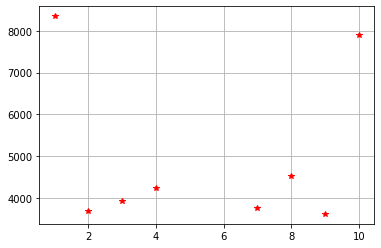

In [7]:
rating, value=np.unique(y,return_counts=True)
print(dict(zip(rating, value)))
plt.plot(rating,value,'*r')
plt.grid()


###  Pré processamento de dados de texto

Usamos este metodo para préprocessar os dados de texto, e reduzir as palavras tendo em conta os erros de ortografia

O stemmer por defeito é o lancaster, porque teve os melhores resultados e se o argumento não corresponder a nenhum outro, este é utilizado

In [10]:
def preProcessDoc(Doc, stemmer = 'lancaster', decode = False):
    stem = {
        'porter'   : PorterStemmer(),
        'snowball' : SnowballStemmer('english'),
        'lancaster': LancasterStemmer()
    }
    stemFunc = stem.get(stemmer, LancasterStemmer())
    if(decode):
        Doc = Doc.decode('UTF-8')
    Doc = Doc.replace('<br />', ' ')
    Doc = re.sub(r'[^a-zA-Z\u00C0\u00FF]+', ' ', Doc)
    Doc = ' '.join([stemFunc.stem(w) for w in Doc.split()])
    return Doc

def preProcessDocs(Docs, stemmer='lancaster', decode = False):
    return [preProcessDoc(doc, stemmer, decode) for doc in Docs]

def text2vector(Docs, preProcess = False, stemmer='lancaster', decode=False):
    if(preProcess):
        Docs = preProcessDocs(Docs, stemmer=stemmer, decode=decode)
    
    global tfidf
    try:
        tfidf ## ver se tfidf já está definido
    except:
        tfidf = pickle.load(open('tfidf_dump.p','rb'))

        
    return tfidf.transform(Docs)

## Classificação Binária

Converter da escala de 0 a 10, para negativos/positivos

In [20]:
y_boolean = [0 if val<5 else 1 for val in y]

### Steemers

O stemmer reduz uma palavra á sua raiz, ou seja, remove plurais, conjugacao de verbos, etc

#### Porter

In [7]:
X = preProcessDocs(Docs, stemmer='porter')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 26773
0.9455


#### Snowball

In [8]:
X = preProcessDocs(Docs, stemmer='snowball')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 26394
0.945375


#### Lancaster

In [9]:
X = preProcessDocs(Docs, stemmer='lancaster')
tfidf = TfidfVectorizer(min_df=3, token_pattern=r'\b[a-zA-Z]{3,}\b').fit(X)
vector = text2vector(X)
dl = LogisticRegression(max_iter = 1000, C=3.3, tol = 1e-3).fit(vector,y_boolean)
print('Token len' , len(tfidf.get_feature_names()))
print(dl.score(vector, y_boolean))

Token len 21883
0.9394


In [10]:
print('P' ,26773/0.945525)
print('S' ,26394/0.94535)
print('L' ,21883/0.939425)

P 28315.486105602708
S 27919.818056804357
L 23294.036245575753


É possivel ver que o lancaster é o que reduz ao maximo a quantidade de tokens, alem disso vamos optar por utilizar o Lancaster pois precisava de uma quantidade de tokens menores para atingir os teoricos 100%

## Comparar modelos lineares

In [12]:
with open('docs_dump.p', 'rb') as f:
    X = pickle.load(f)

In [11]:
X = preProcessDocs(Docs)
with open('docs_dump.p', 'wb') as f:
    pickle.dump(X, f)

In [6]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    global pipeline, grid_param, grid_search
    
    pipeline =Pipeline([
        ('tfidf' , TfidfVectorizer()),
        ('clf' , LogisticRegressionCV(max_iter = 1000, tol=1e-3))
    ], memory=tmpdir, verbose=True)

    grid_param ={
        'tfidf__strip_accents' :[None, 'unicode'],
        #'tfidf__stop_words' : [None, 'english'],
        'tfidf__token_pattern' : [r'\b\w{3,}\b', r'\b[a-zA-Z]{3,}\b'],
        'tfidf__min_df' : np.arange(3, 5, 1),
        'tfidf__max_df' : [0.25, 0.5, 0.75],
        #'tfidf__min_df' : [3,4,5],
        #'tfidf__min_df' : [3],
        #'tfidf__ngram_range' : [(i,j) for i in range(1,5) for j in range(1,5)],
        'tfidf__ngram_range' : [(1,1), (1,2), (1,3) , (2,2)] ,
        'tfidf__norm' : ['l1', 'l2'],
        'tfidf__max_features' : [None, 15000,20000,25000,30000],

       


        #'clf__C' : np.linspace(0.1,10,100),
        'clf__Cs' : [1,3,10,30,100], 
        #'clf__C' : [3.3],
        'clf__solver' : ['sag', 'saga'],
        #'clf__tol' : (1e-3, 1e-4, 1e-5)
    }
    t0 =time.localtime()
    print('Started at'  , time.strftime("%H:%M:%S", t0))
    ## Se tiveres mais memoria que eu(8Gb), aumenta o pre_dispatch para um valor maior
    grid_search = RandomizedSearchCV(pipeline, grid_param, cv = 3, n_jobs=-1, verbose=3,\
                                     pre_dispatch=8,n_iter = 30).fit(X, y_boolean)

    t1 = time.localtime()
    print('Done at' , time.strftime("%H:%M:%S", t1))
with open('dump.p', 'wb') as f:
    pickle.dump({'in' : grid_param ,
                 'out': grid_search}, f)

Started at 15:16:13
Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 56.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 28.11s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Done at 16:17:27


In [7]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
             print('\t' * (indent+1) + str(value))

pretty(grid_search.cv_results_, 0)

mean_fit_time
	[690.02867977  37.32141058 369.89045056 137.35754371 456.18932152
 184.8494792  236.27336701 402.69934948 289.6661249  756.45097788
 268.18874661 187.31101513  66.68613791 175.29305712  90.3015159 ]
std_fit_time
	[ 5.4261045   4.62307497 50.23601666  1.57604928  8.96949775  3.51713334
  4.20336944  3.99793306 11.44582785 18.09002713  7.72037476  1.22601322
  0.6180658   4.00822898 15.02676939]
mean_score_time
	[7.50773851 5.12932785 6.34752345 4.35355218 5.90589515 6.3094004
 4.53880405 6.44200897 3.91615399 5.21079381 9.53086813 6.47203175
 6.27580039 4.19172374 2.21245686]
std_score_time
	[0.21851615 0.71846843 0.46596361 0.10303288 0.20755637 0.20009386
 0.14472093 0.11510817 0.48230765 0.36749729 0.60210629 0.21899587
 0.3289914  0.46973708 0.67657892]
param_tfidf__token_pattern
	['\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b'
 '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b'
 '\\b[a-zA-Z]{3,}\\b' '\\b[a-zA-Z]{3,}\\b' '\\b\\w{3,}\\b' '\\

In [15]:
print(grid_search.best_index_)
print(grid_search.best_estimator_)

0
Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache_mwl12peq',
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 st...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('norm', Normalizer(copy=True, norm='l1')),
                ('clf',
                 LogisticRegressionCV(Cs=3, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                            

## Em vez de correr o codigo em cima, podemos fazer import do ficheiro dump

In [4]:
with open('dump.p' ,'rb') as f:
    global grid_param, grid_search
    temp = pickle.load(f)
    grid_param = temp['in']
    grid_search = temp['out']
print(grid_search.best_estimator_)

Pipeline(memory='C:\\Users\\pedro\\AppData\\Local\\Temp\\sklearn_graph_cache_mwl12peq',
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.75, max_features=None,
                                 min_df=4, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 st...
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('norm', Normalizer(copy=True, norm='l1')),
                ('clf',
                 LogisticRegressionCV(Cs=3, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                              

###  TFIDF optimizado

In [10]:
with open('tfidf_dump.p', 'wb') as f:
    tfidf = TfidfVectorizer(max_df=0.75 , min_df=4,ngram_range=(1, 2), norm='l2', token_pattern=r'\b\w{3,}\b',).fit(X)
    pickle.dump(tfidf, f)

In [11]:
len(tfidf.get_feature_names())

210238

### Classificacao booleana

In [16]:
vector = text2vector(X)

In [17]:
with open('vector_dump.p', 'wb') as f:
    pickle.dump(vector, f)

In [5]:
with open('vector_dump.p', 'rb') as f:
    vector = pickle.load(f)

In [21]:
##tfidf = TfidfVectorizer(min_df = 3, token_pattern=r'\b\w{3,}\b', norm = 'l2' , ngram_range=(1,2)).fit(Docs)
dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(vector,y_boolean)
print(dl.score(vector, y_boolean))
print(dl.scores_)

1.0
{1: array([[0.50525 , 0.888   , 0.896375],
       [0.50525 , 0.89375 , 0.902625],
       [0.50525 , 0.89875 , 0.90475 ],
       [0.50525 , 0.903875, 0.913625],
       [0.50525 , 0.895625, 0.909   ]])}


In [22]:
x_train, x_test, y_train, y_test = train_test_split(vector, y_boolean, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

1.0
0.899


### Classificacao multi-classe

In [23]:
x_train, x_test, y_train, y_test = train_test_split(vector, y, test_size=1/4)

dl = LogisticRegressionCV(max_iter = 1000, Cs=3, tol = 1e-3, cv=5, penalty='l2', solver='saga').fit(x_train, y_train)
print(dl.score(x_train, y_train))
print(dl.score(x_test, y_test))

0.8051
0.4466


# Linear SVC (multiclasse)

In [24]:
help(LinearSVC)

Help on class LinearSVC in module sklearn.svm._classes:

class LinearSVC(sklearn.base.BaseEstimator, sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin)
 |  LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, class_weight=None, verbose=0, random_state=None, max_iter=1000)
 |  
 |  Linear Support Vector Classification.
 |  
 |  Similar to SVC with parameter kernel='linear', but implemented in terms of
 |  liblinear rather than libsvm, so it has more flexibility in the choice of
 |  penalties and loss functions and should scale better to large numbers of
 |  samples.
 |  
 |  This class supports both dense and sparse input and the multiclass support
 |  is handled according to a one-vs-the-rest scheme.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  penalty : str, 'l1' or 'l2' (default='l2')
 |      Specifie

In [22]:
X1,X2,y1,y2=train_test_split(vector,y,test_size=1/5,shuffle=False)

In [23]:
svm=LinearSVC(dual=False,C=1).fit(X1,y1)

In [24]:
ye=svm.predict(X2)

In [25]:
print("tamanho y: ",y.shape)
print("tamanho ye: ",ye.shape)
print('N erros(teste):',np.sum(y2!=ye))

tamanho y:  (40000,)
tamanho ye:  (8000,)
N erros(teste): 4813


In [26]:
print("Linear SVC Score train: ", svm.score(X1,y1))

Linear SVC Score train:  0.85334375


In [27]:
print("Linear SVC Score test: ", svm.score(X2,y2))

Linear SVC Score test:  0.398375


Estas condições de teste não são as mais adecuadas para o conjunto de dados pois como podemos visualizar no teste acima, os valores de score para o conjunto de train e teste são bastante díspares,sendo o de train bastante bom ao contrário do de test que não é muito bom.

# Linear SVC (booleana)

In [14]:
X1,X2,y1,y2=train_test_split(vector,y_boolean,test_size=1/5,shuffle=False)

In [15]:
svm=LinearSVC(dual=False,C=1).fit(X1,y1)

In [16]:
ye=svm.predict(X2)

In [17]:
print("tamanho y: ",y.shape)
print("tamanho ye: ",ye.shape)
print('N erros(teste):',np.sum(y2!=ye))

tamanho y:  (40000,)
tamanho ye:  (8000,)
N erros(teste): 716


In [20]:
print("Linear SVC Score test: ", svm.score(X1,y1))

Linear SVC Score test:  0.9993125


In [21]:
print("Linear SVC Score test: ", svm.score(X2,y2))

Linear SVC Score test:  0.9105


## Decomposição em componentes principais

Temos 4000 documentos, com 240000 tokens, logo para reduzir a complixidade usamos LDA. A LDA remove os componentes com pouco relevo.

In [7]:
vector.shape

(40000, 210238)

### Não repetir, demora muito, tipo umas três horas

In [10]:
pca = TruncatedSVD(n_components=100).fit(vector, y_boolean)

In [8]:
sum(pca.explained_variance_ratio_)

0.05593491422460291

In [8]:
with open('pca_dump.p' ,'wb') as f:
    pickle.dump(pca , f)

In [80]:
list = [10,20,30,50,100,200,300,500]

for n_comps in list:
    pca = TruncatedSVD(n_components=n_comps, n_iter=2).fit(vector)
    print(f'Num Componentes {n_comps : >10} ||  Variance {pca.explained_variance_ratio_.sum() : .10f}')

Num Componentes         10 ||  Variance  0.0145753481
Num Componentes         20 ||  Variance  0.0210284684
Num Componentes         30 ||  Variance  0.0261841245
Num Componentes         50 ||  Variance  0.0347922198
Num Componentes        100 ||  Variance  0.0521353079
Num Componentes        200 ||  Variance  0.0791129334
Num Componentes        300 ||  Variance  0.1008270827
Num Componentes        500 ||  Variance  0.1364963751


In [8]:
with open('pca_dump.p' , 'rb') as f:
    global pca
    pca = pickle.load(f)

In [9]:
pca

TruncatedSVD(algorithm='randomized', n_components=2100, n_iter=5,
             random_state=None, tol=0.0)

In [10]:
vec = pca.transform(vector)
vec.shape

(40000, 2100)

In [56]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y_boolean)
print(dl.score(vec, y_boolean))
for y, score in dl.scores_.items():
    print(f'Class {y} \nScore {score}\n\n')

0.905675
Class 1 
Score [[0.50525  0.8885   0.8805  ]
 [0.50525  0.89275  0.89275 ]
 [0.50525  0.89325  0.89375 ]
 [0.50525  0.898875 0.89775 ]
 [0.50525  0.891875 0.893   ]]




In [61]:
dl = LogisticRegressionCV(Cs=3, max_iter=1000, multi_class='auto', n_jobs=-1, penalty='l2', solver='saga', 
                     tol=0.001).fit(vec, y)
print(dl.score(vec, y))
for y, score in dl.scores_.items():
    print(f'Class {y} \nScores\n{score}\n\n')

0.51155
Class 1 
Score [[0.208875 0.437625 0.39725 ]
 [0.208875 0.44675  0.40175 ]
 [0.20875  0.447875 0.409   ]
 [0.20875  0.439    0.398875]
 [0.20875  0.4465   0.408125]]


Class 2 
Score [[0.208875 0.437625 0.39725 ]
 [0.208875 0.44675  0.40175 ]
 [0.20875  0.447875 0.409   ]
 [0.20875  0.439    0.398875]
 [0.20875  0.4465   0.408125]]


Class 3 
Score [[0.208875 0.437625 0.39725 ]
 [0.208875 0.44675  0.40175 ]
 [0.20875  0.447875 0.409   ]
 [0.20875  0.439    0.398875]
 [0.20875  0.4465   0.408125]]


Class 4 
Score [[0.208875 0.437625 0.39725 ]
 [0.208875 0.44675  0.40175 ]
 [0.20875  0.447875 0.409   ]
 [0.20875  0.439    0.398875]
 [0.20875  0.4465   0.408125]]


Class 7 
Score [[0.208875 0.437625 0.39725 ]
 [0.208875 0.44675  0.40175 ]
 [0.20875  0.447875 0.409   ]
 [0.20875  0.439    0.398875]
 [0.20875  0.4465   0.408125]]


Class 8 
Score [[0.208875 0.437625 0.39725 ]
 [0.208875 0.44675  0.40175 ]
 [0.20875  0.447875 0.409   ]
 [0.20875  0.439    0.398875]
 [0.20875  0.4465

### Clustering

Depois de termos os componentes principais podemos partir para o clustering

In [11]:
x_train,x_test, y_train, y_test = train_test_split(vec,y,test_size=1/4,shuffle=True)

In [12]:
km = KMeans(len(np.unique(y_train)) , init = 'k-means++', n_init = 10, tol = 0.0001, n_jobs = -1 , algorithm = 'full')

print("Clustering sparse data with %s" % km)
t0 =time.time()
km.fit(x_train, y_train)
print(f'Done at {time.strftime("%H:%M:%S", time.localtime())} took {time.time()-t0} seconds' )

Clustering sparse data with KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
Done at 18:16:34 took 335.47119331359863 seconds


In [ ]:
len(np.unique(y))

In [14]:
print(km.score(x_train, y_train))
print(km.score(x_test, y_test))


-8890.856953374212
-2972.371639830966


In [18]:
with TemporaryDirectory(prefix="sklearn_graph_cache_") as tmpdir:
    global pipeline, grid_param, grid_search
    
    pipeline =Pipeline([
        ('kmeans', KMeans(n_jobs=-1))
    ], memory=tmpdir, verbose=True)

    grid_param ={
        'kmeans__n_clusters' : [len(np.unique(y_train)) , 10, 20, 30, 40, 50, 100]
        
    }
    
    t0 = time.time()
    print('Started at'  , time.strftime("%H:%M:%S", time.localtime()))
    ## Se tiveres mais memoria que eu(8Gb), aumenta o pre_dispatch para um valor maior
    grid_search = GridSearchCV(pipeline, grid_param, cv = 5, n_jobs=-1, verbose=2,\
                                     pre_dispatch=8,n_iter = 30, scoring=).fit(x_train,y_train)

    print('Done at' , time.strftime("%H:%M:%S", time.localtime()))
    print('Took ' , time.time() - t0)
    
    
with open('dump_kmeans.p', 'wb') as f:
    pickle.dump({'in' : grid_param ,
                 'out': grid_search}, f)

Started at 18:28:07
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 25.8min finished


[Pipeline] ............ (step 1 of 1) Processing kmeans, total= 6.6min
Done at 19:00:31
Took  1943.4883439540863


In [44]:
km = grid_search.best_estimator_[0]
labels = km.predict(x_train)
str(silhouette_score(x_train, labels, metric='euclidean'))

'0.00525086614013501'

In [35]:
print("Top terms per cluster:")
km = grid_search.best_estimator_[0]
original_space_centroids = pca.inverse_transform(km.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]


terms = tfidf.get_feature_names()
for i in range(len(grid_search.best_estimator_[0].cluster_centers_)):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: surf wav skateboard sport docu the surf crocodil big wav surf and skat
Cluster 1: his with him who for film but was has man
Cluster 2: film the film was with for but not thi film act his
Cluster 3: lov movy thi movy gre you story with was lov the film
Cluster 4: was movy but wer for film not act thi movy had
Cluster 5: seag stev stev seag van dam dam movy van his act film
Cluster 6: dinosa mummy the dinosa the mummy rex movy was film they aztec
Cluster 7: columbo falk episod columbo movy murd pet falk culp pet the columbo his
Cluster 8: hav been hav been was movy could could hav would film but
Cluster 9: she her with was but for film who movy has
Cluster 10: gam the gam thi gam play you graph for gam the video gam gam and
Cluster 11: hor film movy hor movy hor film you but for was with
Cluster 12: tarz jan tarz and jungl the jungl weissmul his film eleph tarz movy
Cluster 13: origin the origin was movy film hav you sequel for remak
Cluster 14: you movy

## Clustering, demora um bocado. Tipo 2 horas
Ajuda a calcular o numero de cluster otimo, entre 8 e max_k

In [65]:
min_k = len(np.unique(y))
max_k = 100
indx = np.linspace(min_k,max_k, num=20, dtype=np.uint8)
sse = []

for k in indx:
    kmeans = KMeans(n_clusters = k)

    sse.append(kmeans.fit(x_train).inertia_)
    print (str(k) + ": "+ str(silhouette_score(x_train, kmeans.labels_, metric='euclidean')))

8: 0.004736857292732877
12: 0.00299289037183781
17: 0.0040322878747390475
22: 0.0039857350520540865
27: 0.0034824348713610506
32: 0.0025221054627285306
37: 0.005015730554904914
41: 0.002570932085156739
46: 0.002864267912859411
51: 0.0034511485682284597
56: 0.004602328488701582
61: 0.005469191272531168
66: 0.004753186840875546
70: 0.005941789163240467
75: 0.0049120232280539435
80: 0.00524685217498796
85: 0.004874927221874257
90: 0.006555116031353104
95: 0.0040383966951680235
100: 0.0067068067075991365


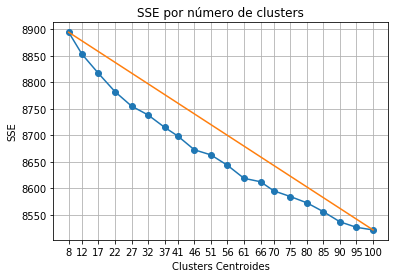

In [68]:
plt.plot(indx, sse, marker='o')
plt.plot([min_k, max_k] , [wcss[0], sse[len(sse)-1]])


plt.xlabel('Clusters Centroides')
plt.xticks(indx)
plt.ylabel('SSE')
plt.title('SSE por número de clusters')
plt.grid(True)


In [87]:
wcss = sse

x1, y1 = min_k, wcss[0]
x2, y2 = max_k, wcss[len(wcss)-1]

distances = []
for i in range(len(wcss)):
    x0 = indx[i]
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(np.round(numerator/denominator , 6))

best_n = indx[distances.index(max(distances))]

In [52]:
with open('dump_cluster.p ', 'wb') as f:
    pickle.dump({
        'indx' : indx,
        'sse' : sse,
        'distances' : distances,
        'best_n' : best_n
    })

0

In [89]:
best_n

46

# Bibliografia

### Geral
- Slides Professor

### Pré processamento do texto
- https://blog.ekbana.com/pre-processing-text-in-python-ad13ea544dae
- https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc

### Escolher o classificador
- https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Grid Search
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
- https://www.youtube.com/watch?v=Gol_qOgRqfA

### Pipeline
- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

### Clustering
- https://medium.com/hanman/data-clustering-what-type-of-movies-are-in-the-imdb-top-250-7ef59372a93b
- https://jtemporal.com/kmeans-and-elbow-method/

### Decomposição PCA/LSA
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD
- https://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
- https://towardsdatascience.com/latent-semantic-analysis-intuition-math-implementation-a194aff870f8